# 事前環境設定

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as stat
import warnings
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
df_train = pd.read_csv('./train.csv')

## 例：立地を元のモデルに追加してみる

# 可視化

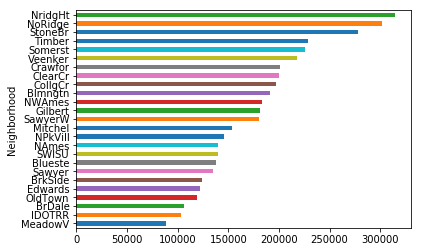

In [3]:
# 地域別価格の中央値
df_train['SalePrice'].groupby(df_train['Neighborhood']).median().sort_values().plot('barh')

In [4]:
# 地域別価格のサマリー
df_train.groupby('Neighborhood').SalePrice.median().describe()

count        25.000000
mean     176515.960000
std       60700.369519
min       88000.000000
25%      135000.000000
50%      179900.000000
75%      200624.000000
max      315000.000000
Name: SalePrice, dtype: float64

In [5]:
# 価格の中央値によりA、Bラベルを付ける
nb_bins=df_train.loc[:,['Neighborhood','SalePrice']]
nb_bins.loc[nb_bins['SalePrice']>=179900,'bins']='A'
nb_bins.loc[nb_bins['SalePrice']<179900,'bins']='B'

In [6]:
# 地域の組み分けリストの作成
nb_list=pd.DataFrame()
for i in nb_bins['Neighborhood']:
    bins = nb_bins.loc[nb_bins['Neighborhood']==i,'bins'].describe()['top']
    AP=pd.DataFrame([i,bins]).T
    nb_list = nb_list.append(AP)
nb_list=nb_list.drop_duplicates()
nb_list.index=range(len(nb_list))
nb_list.columns=['Neighborhood','bin']
nb_list

,Neighborhood,bin
0,CollgCr,A
1,Veenker,A
2,Crawfor,A
3,NoRidge,A
4,Mitchel,B
5,Somerst,A
6,NWAmes,A
7,OldTown,B
8,BrkSide,B
9,Sawyer,B


In [7]:
#　作成されたリストのチェック
len(nb_list)==len(df_train['Neighborhood'].value_counts())

True

In [8]:
def preprocess(train_flg,nb_list):
    if train_flg:
        df = pd.read_csv('./train.csv')
        df.drop(df[df['GrLivArea']>=4000].index,inplace=True)
        df_y=df['SalePrice']
    else:
        df = pd.read_csv('./test.csv')
    cols=['GrLivArea','YearBuilt','OverallCond','BsmtQual','Neighborhood']
    df_x = df.loc[:,cols]
    # 立地を地域リストにより変換
    for i in range(len(nb_list)):
        df_x.loc[df_x['Neighborhood']==nb_list.loc[i,'Neighborhood'],'Neighborhood'] = nb_list.loc[i,'bin']
        
    df_x.loc[df_x['BsmtQual'].isnull()==True,'BsmtQual']='NA'
    df_x=pd.get_dummies(df_x)
    if train_flg:
        return df_x,df_y
    else:
        return df_x,df['Id']

In [9]:
df_x,df_y=preprocess(True,nb_list)

## 線形回帰

In [10]:
clf = stat.OLS(df_y,df_x)
result = clf.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     667.3
Date:                Sun, 21 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:26:33   Log-Likelihood:                -17317.
No. Observations:                1456   AIC:                         3.465e+04
Df Residuals:                    1447   BIC:                         3.470e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
GrLivArea         82.1594      2.127     38.627      0.000      77.987      86.332
YearBuilt        717.5461     52.227     13.739      0.000     615.097     819.995
OverallCond     9766.5959    912.761     10.700      0.000    7976.120    1.16e+04
BsmtQual_Ex    -3.287e+05   3.17e+04    -10.356      0.000   -3.91e+05   -2.66e+05
BsmtQual_Fa     -4.15e+05   2.86e+04    -14.488      0.000   -4.71e+05   -3.59e+05
BsmtQual_Gd    -4.117e+05    3.1e+04    -13.292      0.000   -4.73e+05   -3.51e+05
BsmtQual_NA    -4.405e+05      3e+04    -14.669      0.000   -4.99e+05   -3.82e+05
BsmtQual_TA    -4.148e+05   2.96e+04    -14.014      0.000   -4.73e+05   -3.57e+05
Neighborhood_A -9.947e+05   7.54e+04    -13.190      0.000   -1.14e+06   -8.47e+05
Neighborhood_B -1.016e+06   7.44e+04    -13.665      0.000   -1.16e+06    -8.7e+05
==============================================================================
Omnibus:                      340.386   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2148.757
Skew:                           0.932   Prob(JB):                         0.00
Kurtosis:                       8.652   Cond. No.                     2.06e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.14e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

RMSE:35405.6502428004


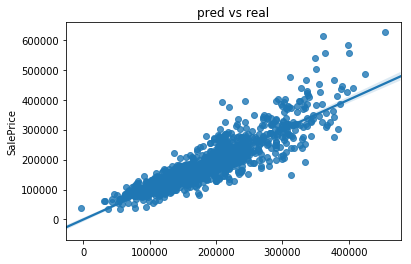

Text(0.5, 1.0, 'Coefficients in the Linear Model')

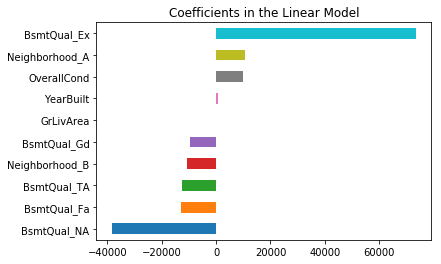

In [11]:
clf=LinearRegression()
clf.fit(df_x,df_y)
print('RMSE:{0}'.format(rmse(clf.predict(df_x),df_y)))
sns.regplot(clf.predict(df_x),df_y)
plt.title('pred vs real')
plt.show()
coef=pd.Series(clf.coef_, index = df_x.columns)
coef.sort_values(ascending=True).plot('barh')
plt.title('Coefficients in the Linear Model')

# テストセットの予測

In [ ]:
df_test_x,df_test_id = preprocess(False,nb_list)

In [ ]:
# 上記の線形モデルで価格を予測、CSV出力
df_test_x=pd.get_dummies(df_test_x)
y_pred=clf.predict(df_test_x)
pred_df=pd.DataFrame(y_pred, index=df_test_id, columns=["SalePrice"])
pred_df.to_csv('./output.csv', header=True, index_label='Id')

# Appendix　変換辞書の作成

## 例：販売月（MoSold）

In [ ]:
df_train.groupby(['MoSold']).SalePrice.count().plot('bar')

In [ ]:
mo_bins = {
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3,
    7:3,
    8:2,
    9:1,
    10:1,
    11:1,
    12:1
}
def get_bins(x):
    x = mo_bins[x]
    return x
df_train['MoSold'].apply(get_bins)